# OOD detection applied to Hallucination Detection

 The goal is to predict if an INPUT prompt  is going to produce an hallucination or not (using OOD detection methods). For now, we don’t look at the output generated by the model, we may consider this in a second time. Retrieve ID samples:  To do this, take a general (easy) QA dataset containing questions along with their true hallucination-free answers. Feed the questions to the model. Let the model generate responses and check if the a given generated response is the same as the real hallucination-free answer. All the correct generated responses will be considered ID. More precisely, the ID dataset will consist of the embeddings of the last token of the last layer of the input (or maybe middle layer) of the correct generated responses.  Test a new sample to see if this is going to be OOD=hallucination: Take another dataset containing questions susceptible to trigger hallucinations along with the true hallucination-free answers (or no answer if the model cannot know the answer by any way and all response that the model might produce will necessarily be hallucinated). Feed a question to the model and let it generate a response. Check by comparing to the hallucination-free answer is that generated response is hallucinated or not. At the same time, apply an OOD detection method on the input question (at the last token last layer) and see if there is a correspondence between a high OOD score and a generated hallucination. 

In [ ]:
#/home/lila.roig/.env/ood_env/bin/python 

In [1]:
%load_ext autoreload
%autoreload 2

## 1. Embedding Extraction

In [2]:
# import libraries
# -----------------------------------
import torch
import sys
import time 
import os 
import pickle
from functools import partial
# Add the path to the src directory
sys.path.append(os.path.abspath(".."))

In [50]:
# Define global variables
# -----------------------------------
SEED = 777 #44
BATCH_SIZE = 16 #32
MODEL_NAME = "meta-llama/Llama-2-7b-chat-hf"
OUTPUT_DIR = "../results/raw/TEST/" 
PLOT_DIR   = "../results/figures/" 
LAYERS = [18,-1] # (List[int]) - Layers from witch retrieve the embeddings 
ACTIVATION_SOURCE = "generation" # can be 'generation', 'PromptGeneration'

HIDDEN_AGG = ["average", "last", "max", "first_generated", "token_svd_score", "feat_var"]
ATTN_AGG = ["attn_eig_prod"]
LOGIT_AGG = ["perplexity", "logit_entropy", "window_logit_entropy"]
LOGIT_CONFIG = {"top_k": 50, "window_size": 1, "stride": 1}

STR_SCORES = 'all_hidden_attn_logit'

In [4]:
# Clear memory to avoid "CUDA out of memory"
# -----------------------------------
torch.cuda.empty_cache()
torch.cuda.ipc_collect()

In [47]:
# Visualize setup 
# -----------------------------------
print(f"Python version: {sys.version}")
print(f"Cuda version: {torch.version.cuda}")
num_gpus = torch.cuda.device_count()
print(f"Number of available de GPU : {num_gpus}")
for i in range(num_gpus):
    print(f"GPU {i + 1} : {torch.cuda.get_device_name(i)}")

Python version: 3.11.13 (main, Jun  4 2025, 08:57:30) [GCC 13.3.0]
Cuda version: 12.6
Number of available de GPU : 2
GPU 1 : NVIDIA L40S
GPU 2 : NVIDIA L40S


In [48]:
# Seed everything
# -----------------------------------
from src.utils.general import seed_all
seed_all(SEED)

## Load model

In [49]:
# Load model
# -----------------------------------
from src.model_loader.llama_loader import load_llama

model, tokenizer = load_llama(MODEL_NAME)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

### Load ID dataset

For the ID general dataset, we are going to use the SQUAD 1.1 dataset: 

***SQuAD 1.1:** Comprises over 100,000 question-answer pairs derived from more than 500 Wikipedia articles. Each question is paired with a specific segment of text (a span) from the corresponding article that serves as the answer.*

In [11]:
# Load ID dataset
# -----------------------------------
from src.data_reader.squad_loader import load_id_fit_dataset 
# Total number of samples in squad v1.1: 87599, squad v2.0: 86821

id_fit_dataset = load_id_fit_dataset()
#id_fit_dataset = id_fit_dataset.shuffle(SEED) 
id_fit_dataset = id_fit_dataset.slice(idx_start=0, idx_end=None) # 10_000
id_fit_dataset.print_info()


===== Dataset Information =====
Dataset({
    features: ['id', 'title', 'context', 'question', 'answers', 'original_index', 'is_impossible'],
    num_rows: 86821
})
Mean ground-truth answer length: 3.16, Max length: 43
Mean context + question length: 129.86, Max length: 666


In [12]:
# Visualize one generation with the ID dataset
# -----------------------------------
'''
from src.inference.run_extraction import analyze_single_generation, build_prompt
from src.inference.hooks import register_forward_activation_hook, extract_token_activations

_ = analyze_single_generation(
    model=model,
    tokenizer=tokenizer,
    dataset=id_fit_dataset,
    sample_idx=3,
    build_prompt_fn=build_prompt,
    register_forward_activation_hook_fn=register_forward_activation_hook,
    layer_idx=-1,
    extract_token_activations_fn=partial(extract_token_activations, mode=EXTRACTION_MODE),
) 
'''

'\nfrom src.inference.run_extraction import analyze_single_generation, build_prompt\nfrom src.inference.hooks import register_forward_activation_hook, extract_token_activations\n\n_ = analyze_single_generation(\n    model=model,\n    tokenizer=tokenizer,\n    dataset=id_fit_dataset,\n    sample_idx=3,\n    build_prompt_fn=build_prompt,\n    register_forward_activation_hook_fn=register_forward_activation_hook,\n    layer_idx=-1,\n    extract_token_activations_fn=partial(extract_token_activations, mode=EXTRACTION_MODE),\n) \n'

### Define more global variables

In [13]:
# Compute offsets to select the tokens to give to the model
# -----------------------------------
from src.inference.generation_utils import build_prompt
from src.inference.offset_utils import compute_token_offsets

if False:
    idx = 67
    text = build_prompt(id_fit_dataset[idx]["context"], id_fit_dataset[idx]["question"])
    
    START_OFFSET, END_OFFSET = compute_token_offsets(
        text=text,
        tokenizer=tokenizer,
        start_phrase="Passage:", 
        end_phrase=" [/INST]",
        include_start_phrase=True,
        include_end_phrase=False,
        debug=True,
        )

if True:
    START_OFFSET=0
    END_OFFSET=0

In [ ]:
STR_LAYERS =  "_".join(str(x) for x in LAYERS)
OUTPUT_PROMPT_TITLE = f"_layer{STR_LAYERS}_score_{STR_SCORES}_prompt_so{START_OFFSET}_eo{END_OFFSET}"
OUTPUT_GEN_TITLE =  f"_layer{STR_LAYERS}_score_{STR_SCORES}_{ACTIVATION_SOURCE}_so{START_OFFSET}_eo{END_OFFSET}"

print("OUTPUT_TITLE:", OUTPUT_PROMPT_TITLE)
print("OUTPUT_GEN_TITLE:", OUTPUT_GEN_TITLE)

OUTPUT_TITLE: _layer18_-1_score_all_hidden_attn_logit_prompt_so0_eo0
OUTPUT_GEN_TITLE: _layer18_-1_score_all_hidden_attn_logit_generation_so0_eo0


### Compare responses & create new correct dataset

This section only needs to be **RUN ONCE** to compare the ground-truth answers with the generated responses. We will then retain only those generated responses that match the ground-truth answers, effectively creating a new dataset. At this stage, the layer index and the method of token extraction are not relevant—you can set them to any value you like. Our sole focus here is to filter the responses to match the ground truth.

In [ ]:
# Retrieve ID generated responses and compare them to ground-truth 
# -----------------------------------
from src.inference.run_extraction import run_filter_generated_answers_by_similarity
from src.inference.generation_utils import build_prompt
from src.utils.general import print_time_elapsed
from src.data_reader.pickle_io import merge_batches_and_cleanup

output_path = OUTPUT_DIR + "id_fit_results_answers" 

# Runs batched inference on a dataset using a decoder-only language model.
# For each batch, generates answers, computes semantic similarity scores, 
# and appends the results to a pickle file.
print("\nStart generating ID answers and comparing them to ground-truth...")
t0 = time.time()
run_filter_generated_answers_by_similarity(
    model=model,
    tokenizer=tokenizer,
    dataset=id_fit_dataset,
    batch_size=BATCH_SIZE,
    idx_start_sample=0,
    max_samples=len(id_fit_dataset),
    output_path=output_path,
    build_prompt_fn=build_prompt
)
t1 = time.time()
print("...end!")
print_time_elapsed(t0, t1, label="ID answers: ")

# Merge all batches, save as a single file and delete batch directory
_= merge_batches_and_cleanup(directory=output_path, delete=True, confirm='user') 


Start generating ID answers and comparing them to ground-truth...


  0%|          | 0/7 [00:00<?, ?it/s]

100%|██████████| 7/7 [00:10<00:00,  1.46s/it]


...end!
ID answers: Time elapsed: 00 min 10 sec

Directory '../results/raw/TEST/id_fit_results_answers' deleted.


In [18]:
# Load ID responses and only keep correct entries 
# -----------------------------------
from src.data_reader.pickle_io import load_pickle_batches
from src.utils.general import filter_entries

# Load extracted answers 
id_fit_answers = load_pickle_batches(OUTPUT_DIR + "id_fit_results_answers.pkl")
# Only keep rows where the generated responses are similar to the ground-truth answers
ids_correct_answers = filter_entries(id_fit_answers, column='is_correct', value=1)["id"]
# Create a new dataset contaning only the correct answers 
id_fit_correct_dataset =  id_fit_dataset.filter_by_column('id', ids_correct_answers)
# Save the new correct dataset for later use
#id_fit_correct_dataset.save("../data/datasets/id_fit_correct_dataset.pkl")

Loaded 112 samples from: ../results/raw/TEST/id_fit_results_answers.pkl
Size before filtering: 112. Size after filtering: 93. Filtered 19 samples.


In [22]:
# Load correct dataset
# -----------------------------------
with open("../data/datasets/id_fit_correct_dataset.pkl", "rb") as f:
    id_fit_correct_dataset = pickle.load(f)

id_fit_correct_dataset.print_info()


===== Dataset Information =====
Dataset({
    features: ['id', 'title', 'context', 'question', 'answers', 'original_index', 'is_impossible'],
    num_rows: 7998
})
Mean ground-truth answer length: 2.94, Max length: 30
Mean context + question length: 129.50, Max length: 568


### Retrieve ID scores from input

This section must be executed for each configuration to extract the appropriate layer index and token embeddings.

In [ ]:
# Retrieve ID scores and save results 
# -----------------------------------
from src.inference.run_extraction import run_prompt_score_extraction
from src.inference.generation_utils import build_prompt
from src.utils.general import print_time_elapsed
from src.data_reader.pickle_io import merge_batches_and_cleanup

output_path = f"{OUTPUT_DIR}id_fit_results{OUTPUT_PROMPT_TITLE}" 

# Runs batched inference on a dataset using a decoder-only language model.
# For each batch, extracts token-level activations, and appends the results to a pickle file.
print("\nStart retrieving ID fit scores from inputs...")
t2 = time.time()
res = run_prompt_score_extraction(
    model=model,
    tokenizer=tokenizer,
    dataset=id_fit_dataset,
    batch_size=BATCH_SIZE,
    idx_start_sample=0,
    max_samples=len(id_fit_correct_dataset),
    save_to_pkl=False,
    output_path=output_path,
    build_prompt_fn=build_prompt,
    layers=LAYERS,  
    hidden_scores=HIDDEN_SCORES,
    attn_scores=ATTN_SCORES,
    logit_scores=LOGIT_SCORES,
    logit_config=LOGIT_CONFIG,
    start_offset=START_OFFSET,
    end_offset=END_OFFSET
)
t3 = time.time()
print("...end!")
print_time_elapsed(t2, t3, label="ID scores: ")

# Merge all batches, save as a single file and delete batch directory
_= merge_batches_and_cleanup(directory=output_path, delete=True, confirm='user') 


Start retrieving ID fit embeddings from inputs...


  0%|          | 0/7 [00:00<?, ?it/s]

100%|██████████| 7/7 [00:07<00:00,  1.03s/it]

...end!
ID embeddings: Time elapsed: 00 min 07 sec

Directory '../results/raw/TEST/id_fit_results_layer18_-1_token-1_prompt_so0_eo0' does not exist. Nothing to delete.


In [20]:
# Free memory 
del id_fit_dataset 
del id_fit_correct_dataset

### Retrieve ID scores from generated answer

In [ ]:
# Retrieve ID scores and save results 
# -----------------------------------
from src.inference.run_extraction import run_prompt_and_generation_score_extraction
from src.inference.generation_utils import build_prompt
from src.utils.general import print_time_elapsed
from src.data_reader.pickle_io import merge_batches_and_cleanup

output_path = f"{OUTPUT_DIR}id_fit_results{OUTPUT_GEN_TITLE}"

# Runs batched inference on a dataset using a decoder-only language model.
# For each batch, generates answers, extracts token-level activations for the generated answer,
# and appends the results to a pickle file.
print(f"\nStart retrieving ID fit scores from {ACTIVATION_SOURCE}...")
t2 = time.time()
res = run_prompt_and_generation_score_extraction(
    model=model,
    tokenizer=tokenizer,
    dataset=id_fit_dataset,
    batch_size=BATCH_SIZE,
    idx_start_sample=0,
    max_samples=len(id_fit_correct_dataset),
    save_to_pkl=False,
    output_path=output_path,
    build_prompt_fn=build_prompt,
    layers=LAYERS,  
    activation_source=ACTIVATION_SOURCE,
    hidden_scores=HIDDEN_SCORES,
    attn_scores=ATTN_SCORES,
    logit_scores=LOGIT_SCORES,
    logit_config=LOGIT_CONFIG,
    start_offset=START_OFFSET,
    end_offset=END_OFFSET
)
t3 = time.time()
print("...end!")
print_time_elapsed(t2, t3, label="ID scores: ")

# Merge all batches, save as a single file and delete batch directory
_= merge_batches_and_cleanup(directory=output_path, delete=True, confirm='user') 

In [ ]:
# Free memory 
del id_fit_dataset 
del id_fit_correct_dataset

### Load OOD/Hallucinations test datasets 

To evaluate the Hallucination detection in question answering using OOD detection methods, we will use datasets in the SQuAD style:

***SQuAD 2.0:** SQuAD 2.0 extends the original **SQuAD 1.1** dataset by adding around 50,000 unanswerable questions. These questions are carefully designed to look similar to answerable ones, making it more challenging for models to determine when there isn’t enough information in the context to provide an answer.*

**Test Dataset Composition** \
Our test set will include two types of samples:
- ***Impossible samples***: Questions that cannot be answered based on the provided context (i.e., the answer is not present in the text). These are taken from the training split of SQuAD 2.0, selecting only the unanswerable questions.
- ***Possible samples***: Questions where the answer is explicitly present in the context. These are drawn from the validation split of SQuAD 1.1. This ensures there is no overlap with the in-distribution (ID) data from the SQuAD 1.1 training split.

**Note on Evaluation Scope**\
Currently, our evaluation focuses on whether the model can answer questions using only the information provided in the input context. We do not test the model’s internal knowledge or ability to answer questions without supporting context. However, this setup closely matches the OOD scenario: if the information is not in the text, the model should recognize and indicate this.

**Additional Dataset: TriviaQA**\
To further test generalization, we will also use the TriviaQA dataset. Like SQuAD, TriviaQA provides question-answering prompts with supporting context. The model must either extract the correct answer from the context or correctly identify when the answer is not present.


In [60]:
# Load test datasets
# -----------------------------------
from src.data_reader.squad_loader import load_id_test_dataset, load_od_test_dataset

# Load possible test dataset 
id_test_dataset = load_id_test_dataset()
id_test_dataset = id_test_dataset.shuffle(SEED) 
id_test_dataset = id_test_dataset.slice(idx_start=0, idx_end=None) # 1000
id_test_dataset.print_info()

# Load impossible test dataset 
od_test_dataset = load_od_test_dataset()
od_test_dataset = od_test_dataset.shuffle(SEED) 
od_test_dataset = od_test_dataset.slice(idx_start=0, idx_end=None) # 1000
od_test_dataset.print_info()



===== Dataset Information =====
Dataset({
    features: ['id', 'title', 'context', 'question', 'answers', 'original_index', 'is_impossible'],
    num_rows: 5928
})
Mean ground-truth answer length: 3.20, Max length: 29
Mean context + question length: 138.87, Max length: 651

===== Dataset Information =====
Dataset({
    features: ['id', 'title', 'context', 'question', 'answers', 'original_index', 'is_impossible'],
    num_rows: 5945
})
No valid ground-truth answers to compute length stats.
Mean context + question length: 136.99, Max length: 645


In [61]:
# Visualize one generation with the test impossible dataset
# -----------------------------------
'''
from src.inference.inference_utils import analyze_single_generation, build_prompt
from src.inference.activation_utils import register_forward_activation_hook, extract_token_activations

_ = analyze_single_generation(
    model=model,
    tokenizer=tokenizer,
    dataset=od_test_dataset,
    sample_idx=500,
    build_prompt_fn=build_prompt,
    register_forward_activation_hook_fn=register_forward_activation_hook,
    layer_idx=-1,
    extract_token_activations_fn=partial(extract_token_activations, mode=EXTRACTION_MODE),
) 
'''

'\nfrom src.inference.inference_utils import analyze_single_generation, build_prompt\nfrom src.inference.activation_utils import register_forward_activation_hook, extract_token_activations\n\n_ = analyze_single_generation(\n    model=model,\n    tokenizer=tokenizer,\n    dataset=od_test_dataset,\n    sample_idx=500,\n    build_prompt_fn=build_prompt,\n    register_forward_activation_hook_fn=register_forward_activation_hook,\n    layer_idx=-1,\n    extract_token_activations_fn=partial(extract_token_activations, mode=EXTRACTION_MODE),\n) \n'

### Retrieve test embeddings from input

Test embeddings which may be OOD/Hallucinations.

In [ ]:
# Retrieve test scores and save results 
# -----------------------------------
from src.inference.run_extraction import run_prompt_score_extraction
from src.inference.generation_utils import build_prompt
from src.utils.general import print_time_elapsed
from src.data_reader.pickle_io import merge_batches_and_cleanup

od_output_path = f"{OUTPUT_DIR}od_test_results{OUTPUT_PROMPT_TITLE}" 
id_output_path = f"{OUTPUT_DIR}id_test_results{OUTPUT_PROMPT_TITLE}"

# Runs batched inference on a dataset using a decoder-only language model.
# For each batch, extracts token-level activations, and appends the results to a pickle file.
print("\nStart retrieving test impossible scores from inputs...")
t2 = time.time()
res = run_prompt_score_extraction(
    model=model,
    tokenizer=tokenizer,
    dataset=od_test_dataset,
    batch_size=BATCH_SIZE,
    idx_start_sample=0,
    max_samples=len(od_test_dataset),
    save_to_pkl=False,
    output_path=od_output_path,
    build_prompt_fn=build_prompt,
    layers=LAYERS,  
    hidden_scores=HIDDEN_SCORES,
    attn_scores=ATTN_SCORES,
    logit_scores=LOGIT_SCORES,
    logit_config=LOGIT_CONFIG,
    start_offset=START_OFFSET,
    end_offset=END_OFFSET
)
t3 = time.time()
print("...end!")
print_time_elapsed(t2, t3, label="Test impossible scores: ")

print("\nStart retrieving test possible scores from inputs...")
t4 = time.time()
res = run_prompt_score_extraction(
    model=model,
    tokenizer=tokenizer,
    dataset=id_test_dataset,
    batch_size=BATCH_SIZE,
    idx_start_sample=0,
    max_samples=len(id_test_dataset),
    save_to_pkl=False,
    output_path=id_output_path,
    build_prompt_fn=build_prompt,
    layers=LAYERS,  
    hidden_scores=HIDDEN_SCORES,
    attn_scores=ATTN_SCORES,
    logit_scores=LOGIT_SCORES,
    logit_config=LOGIT_CONFIG,
    start_offset=START_OFFSET,
    end_offset=END_OFFSET
)
t5 = time.time()
print("...end!")
print_time_elapsed(t4, t5, label="Test possible scores: ")

# Merge all batches, save as a single file and delete batch directory
_= merge_batches_and_cleanup(directory=od_output_path, delete=True, confirm='user') 
_= merge_batches_and_cleanup(directory=id_output_path, delete=True, confirm='user') 


Start retrieving test impossible scores from inputs...


  0%|          | 0/7 [00:00<?, ?it/s]

100%|██████████| 7/7 [00:06<00:00,  1.02it/s]


...end!
Test impossible scores: Time elapsed: 00 min 06 sec


Start retrieving test possible scores from inputs...


100%|██████████| 7/7 [00:08<00:00,  1.24s/it]

...end!
Test possible scores: Time elapsed: 00 min 08 sec

Directory '../results/raw/TEST/od_test_results_layer18_-1_score_all_hidden_attn_logit_prompt_so0_eo0' does not exist. Nothing to delete.
Directory '../results/raw/TEST/id_test_results_layer18_-1_score_all_hidden_attn_logit_prompt_so0_eo0' does not exist. Nothing to delete.


In [20]:
# Free memory 
del od_test_dataset 
del id_test_dataset

### Retrieve test embeddings from generated answer

In [ ]:
# Retrieve test scores and save results 
# -----------------------------------
from src.inference.run_extraction import run_prompt_and_generation_score_extraction
from src.inference.generation_utils import build_prompt
from src.utils.general import print_time_elapsed
from src.data_reader.pickle_io import merge_batches_and_cleanup

od_output_path = f"{OUTPUT_DIR}od_test_results{OUTPUT_PROMPT_TITLE}" 
id_output_path = f"{OUTPUT_DIR}id_test_results{OUTPUT_PROMPT_TITLE}"

# Runs batched inference on a dataset using a decoder-only language model.
# For each batch, extracts token-level activations, and appends the results to a pickle file.
print(f"\nStart retrieving test impossible scores from {ACTIVATION_SOURCE}...")
t2 = time.time()
res = run_prompt_and_generation_score_extraction(
    model=model,
    tokenizer=tokenizer,
    dataset=od_test_dataset,
    batch_size=BATCH_SIZE,
    idx_start_sample=0,
    max_samples=len(od_test_dataset),
    save_to_pkl=False,
    output_path=od_output_path,
    build_prompt_fn=build_prompt,
    layers=LAYERS,  
    activation_source=ACTIVATION_SOURCE,
    hidden_scores=HIDDEN_SCORES,
    attn_scores=ATTN_SCORES,
    logit_scores=LOGIT_SCORES,
    logit_config=LOGIT_CONFIG,
    start_offset=START_OFFSET,
    end_offset=END_OFFSET
)
t3 = time.time()
print("...end!")
print_time_elapsed(t2, t3, label="Test impossible scores: ")


print(f"\nStart retrieving test possible scores from {ACTIVATION_SOURCE}...")
t4 = time.time()
res = run_prompt_and_generation_score_extraction(
    model=model,
    tokenizer=tokenizer,
    dataset=id_test_dataset,
    batch_size=BATCH_SIZE,
    idx_start_sample=0,
    max_samples=len(id_test_dataset),
    save_to_pkl=False,
    output_path=id_output_path,
    build_prompt_fn=build_prompt,
    layers=LAYERS,  
    activation_source=ACTIVATION_SOURCE,
    hidden_scores=HIDDEN_SCORES,
    attn_scores=ATTN_SCORES,
    logit_scores=LOGIT_SCORES,
    logit_config=LOGIT_CONFIG,
    start_offset=START_OFFSET,
    end_offset=END_OFFSET
)
t5 = time.time()
print("...end!")
print_time_elapsed(t4, t5, label="Test possible scores: ")

# Merge all batches, save as a single file and delete batch directory
_= merge_batches_and_cleanup(directory=od_output_path, delete=True, confirm='user') 
_= merge_batches_and_cleanup(directory=id_output_path, delete=True, confirm='user') 


Start retrieving test impossible embeddings from generation...


  0%|          | 0/7 [00:00<?, ?it/s]

100%|██████████| 7/7 [00:18<00:00,  2.63s/it]


...end!
Test impossible embeddings: Time elapsed: 00 min 18 sec


Start retrieving test possible embeddings from generation...


100%|██████████| 7/7 [00:20<00:00,  2.86s/it]

...end!
Test possible embeddings: Time elapsed: 00 min 20 sec

Directory '../results/raw/TEST/od_test_results_layer18_-1_score_all_hidden_attn_logit_prompt_so0_eo0' does not exist. Nothing to delete.
Directory '../results/raw/TEST/id_test_results_layer18_-1_score_all_hidden_attn_logit_prompt_so0_eo0' does not exist. Nothing to delete.


In [ ]:
# Free memory 
del od_test_dataset 
del id_test_dataset

## Analyse results

In [1]:
# import libraries
# -----------------------------------
import torch
import sys
import os 
import numpy as np
import pandas as pd
# Add the path to the src directory
sys.path.append(os.path.abspath(".."))

### Load extracted embeddings 

In [19]:
SEED = 777 
BATCH_SIZE = 18
LAYER = -1     # can be -1 or 16
TOKENS = "0"   # can be "0" (first token), "-1" (last token), "Avg" (average token), "Max" (max of tokens)
START_OFFSET=0 # always 0 for now
END_OFFSET=0   # always 0 for now
K_BEAMS = 1    # always 1 for now 


# ACTIVATION_SOURCE: if we want to extract the hidden states from the generated answer 
# only or from the prompt+generated answer.
ACTIVATION_SOURCE = "generation" # can be 'generation' or 'PromptGeneration' 

OUTPUT_DIR = "../results/raw/all_config_correct/" 
PLOT_DIR   = "../results/figures/all_config_correct/" 
OUTPUT_PROMPT_TITLE = f"_layer{LAYER}_token{TOKENS}_prompt_so{START_OFFSET}_eo{END_OFFSET}"
OUTPUT_GEN_TITLE =  f"_layer{LAYER}_token{TOKENS}_{ACTIVATION_SOURCE}_kbeams{K_BEAMS}_so{START_OFFSET}_eo{END_OFFSET}"

print("OUTPUT_PROMPT_TITLE:", OUTPUT_PROMPT_TITLE)
print("OUTPUT_GEN_TITLE:", OUTPUT_GEN_TITLE)
print("OUTPUT_DIR:", OUTPUT_DIR)
print("PLOT_DIR:", PLOT_DIR)

# ===================================
# /.\ IMPORTANT
# ===================================
# - Select `OUTPUT_TITLE=OUTPUT_GEN_TITLE` to analyze the embeddings of the response 
# (ACTIVATION_SOURCE='generation') or (ACTIVATION_SOURCE='promptGeneration')
# - Select `OUTPUT_TITLE=OUTPUT_PROMPT_TITLE` to analyze the embeddings of the prompt

OUTPUT_TITLE = OUTPUT_GEN_TITLE
#OUTPUT_TITLE = OUTPUT_PROMPT_TITLE

OUTPUT_PROMPT_TITLE: _layer-1_token0_prompt_so0_eo0
OUTPUT_GEN_TITLE: _layer-1_token0_generation_kbeams1_so0_eo0
OUTPUT_DIR: ../results/raw/all_config_correct/
PLOT_DIR: ../results/figures/all_config_correct/


In [ ]:
from src.data_reader.pickle_io import get_dir_size
_=get_dir_size(OUTPUT_DIR)

Size of Directory ../results/raw/all_config_correct/: 1014.98 MB


In [20]:
# Load ID embeddings 
# -----------------------------------
from src.data_reader.pickle_io import load_pickle_batches
from src.utils.general import add_unanswerable_flag, filter_entries

# Load extracted embeddings 
id_fit_data = load_pickle_batches(f"{OUTPUT_DIR}id_fit_results{OUTPUT_TITLE}.pkl")

# Add unanswerable flag: check if the generated answer contains 'unanswerable' keyword
# Expect many 'unanswerable' flags in `od_test_data` and few in `id_test_data`, if model works well
id_fit_data = add_unanswerable_flag(id_fit_data)

# Filter embeddings: keep only answerable answers for ID
if False:
    id_fit_data = filter_entries(id_fit_data, column='is_unanswerable', value=0)

# Convert numpy arrays into torch tensors
id_fit_embeddings = [torch.from_numpy(arr) for arr in id_fit_data['activations']]

# Concatenate all embeddings 
id_fit_embeddings = torch.cat(id_fit_embeddings, dim=0) # shape: [n_samples, hidden_size]


Loaded 8008 samples from: ../results/raw/all_config_correct/id_fit_results_layer-1_token0_generation_kbeams1_so0_eo0.pkl


In [21]:
# Load test embeddings 
# -----------------------------------
from src.data_reader.pickle_io import load_pickle_batches
from src.utils.general import add_unanswerable_flag, filter_entries

# Load extracted possible and impossible embeddings 
od_test_data = load_pickle_batches(f"{OUTPUT_DIR}od_test_results{OUTPUT_TITLE}.pkl")
id_test_data = load_pickle_batches(f"{OUTPUT_DIR}id_test_results{OUTPUT_TITLE}.pkl")

# Add unanswerable flag: check if the generated answer contains 'unanswerable' keyword
# Expect many 'unanswerable' flags in `od_test_data` and few in `id_test_data`, if model works well
od_test_data = add_unanswerable_flag(od_test_data)
id_test_data = add_unanswerable_flag(id_test_data)

# Filter embeddings: keep only unanswerable answers for OOD, and only answerable answers for ID
if False:
    od_test_data = filter_entries(od_test_data, column='is_unanswerable', value=1)
    id_test_data = filter_entries(id_test_data, column='is_unanswerable', value=0)

# Convert numpy arrays into torch tensors
od_test_embeddings = [torch.from_numpy(arr) for arr in od_test_data['activations']]
id_test_embeddings = [torch.from_numpy(arr) for arr in id_test_data['activations']]

# Concatenate possible and impossible all embeddings 
od_test_embeddings = torch.cat(od_test_embeddings, dim=0) # shape: [n_samples, hidden_size]
id_test_embeddings = torch.cat(id_test_embeddings, dim=0) # shape: [n_samples, hidden_size]

Loaded 1000 samples from: ../results/raw/all_config_correct/od_test_results_layer-1_token0_generation_kbeams1_so0_eo0.pkl
Loaded 1000 samples from: ../results/raw/all_config_correct/id_test_results_layer-1_token0_generation_kbeams1_so0_eo0.pkl


In [7]:
# Result DataFrame: Initialization with sample indexes and 'unanswerable' flag
# -----------------------------------
n_id  = len(id_test_data['id'])
n_ood = len(od_test_data['id'])
df_result = pd.DataFrame({
    'set': ['ID'] * n_id + ['OOD'] * n_ood,
    'index': list(range(n_id)) + list(range(n_ood)),
})
df_result['is_unanswerable'] = np.concatenate([
    id_test_data['is_unanswerable'],
    od_test_data['is_unanswerable']
])

### Visualisation

In [8]:
# Plot PCA, t-SNE and UMAP of unclassified samples  
# -----------------------------------
from src.analysis.visualization import plot_dim_reduction_3d_embeddings

pca_config = {'n_components': 3}
tsne_config = {'n_components': 3, 'perplexity': 50}
umap_config = {'n_components': 3, 'n_neighbors': 15, 'min_dist': 0.1}

# --- PCA only ---
_ = plot_dim_reduction_3d_embeddings(
    id_test_embeddings=id_test_embeddings, 
    od_test_embeddings=od_test_embeddings, 
    labels_id=None, 
    labels_ood=None,
    pca_config=pca_config
)

# --- t-SNE only ---
'''
_ = plot_dim_reduction_3d_embeddings(
    id_test_embeddings=id_test_embeddings, 
    od_test_embeddings=od_test_embeddings, 
    labels_id=None, 
    labels_ood=None,
    tsne_config=tsne_config
)

# --- UMAP only ---
_ = plot_dim_reduction_3d_embeddings(
    id_test_embeddings=id_test_embeddings, 
    od_test_embeddings=od_test_embeddings, 
    labels_id=None, 
    labels_ood=None,
    umap_config=umap_config
)
'''

'\n_ = plot_dim_reduction_3d_embeddings(\n    id_test_embeddings=id_test_embeddings, \n    od_test_embeddings=od_test_embeddings, \n    labels_id=None, \n    labels_ood=None,\n    tsne_config=tsne_config\n)\n\n# --- UMAP only ---\n_ = plot_dim_reduction_3d_embeddings(\n    id_test_embeddings=id_test_embeddings, \n    od_test_embeddings=od_test_embeddings, \n    labels_id=None, \n    labels_ood=None,\n    umap_config=umap_config\n)\n'

### Compute OOD scores

In [22]:
# Clear memory to avoid "CUDA out of memory"
# -----------------------------------
torch.cuda.empty_cache()
torch.cuda.ipc_collect()

In [23]:
# ===================================
# Perform DKNN
#
# A high DeepKNN score (distance to k-th NN) => OOD data (far from ID neighbors)
# A low DeepKNN score                        => ID data (close to ID neighbors)
# ===================================
from src.ood_methods.dknn import compute_dknn_scores

# Define config
# -----------------------------------
config = {'k': 1, 'batch_size': BATCH_SIZE}

# Compute DKNN scores on test data
# -----------------------------------
scores_id, scores_ood = compute_dknn_scores(
    id_fit_embeddings=id_fit_embeddings, 
    id_test_embeddings=id_test_embeddings, 
    od_test_embeddings=od_test_embeddings, 
    k=config['k'], 
    batch_size=config['batch_size']
)
print("Mean of ID scores:", np.mean(scores_id))
print("Mean of OOD scores:", np.mean(scores_ood))

# Result DataFrame: Add ood scores
# -----------------------------------
df_result['ood_score'] = np.concatenate([scores_id, scores_ood])


Mean of ID scores: 0.5037803
Mean of OOD scores: 0.5469243


In [17]:
# ===================================
# Perform Cosine Similarity
# 
# A high (oposite) Cosine similarity score => OOD data (different direction) 
# A low  (oposite) Cosine similarity score => ID data (aligned with ID center)
# ===================================
from src.ood_methods.cosine import compute_cosine_similarity

# Define config
# -----------------------------------
config = {'center_type':'all', 'seed': SEED, 'k': 5, 'batch_size': BATCH_SIZE}

# Compute cosine similarity on test data
# -----------------------------------
scores_id, scores_ood = compute_cosine_similarity(
    id_fit_embeddings=id_fit_embeddings,
    id_test_embeddings=id_test_embeddings,
    od_test_embeddings=od_test_embeddings,
    center_type=config['center_type'],
    seed=config['seed'],
    k=config['k'],
    batch_size=config['batch_size']
)
print("Mean of ID scores:", np.mean(scores_id))
print("Mean of OOD scores:", np.mean(scores_ood))

# Result DataFrame: Add ood scores
# -----------------------------------
df_result['ood_score'] = np.concatenate([scores_id, scores_ood])

100%|██████████| 370/370 [01:34<00:00,  3.90it/s]

Mean of ID scores: -0.85136586
Mean of OOD scores: -0.85071856


In [18]:
# ===================================
# Perform Mahalanobis Distance
#
# A high Mahalanobis score => OOD data (far from ID distribution)
# A low Mahalanobis score  => ID data (close to ID distribution)
# ===================================
from src.ood_methods.mahalanobis import compute_mahalanobis_distance

# Define config
# -----------------------------------
config = {'center_type':'mean', 'seed': SEED, 'k': 5}

# Compute mahalanobis distance on test data
# -----------------------------------
scores_id, scores_ood = compute_mahalanobis_distance(
    id_fit_embeddings=id_fit_embeddings,
    id_test_embeddings=id_test_embeddings,
    od_test_embeddings=od_test_embeddings,
    center_type=config['center_type'],
    seed=config['seed'],
    k=config['k']
)
print("Mean of ID scores:", np.mean(scores_id))
print("Mean of OOD scores:", np.mean(scores_ood))

# Result DataFrame: Add ood scores
# -----------------------------------
df_result['ood_score'] = np.concatenate([scores_id, scores_ood])

Mean of ID scores: 216.80530342348175
Mean of OOD scores: 217.1413251140924


In [22]:
# ===================================
# Perform OCSVM 
# 
# A high (oposite) OCSVM score => OOD data 
# A low  (oposite) OCSVM score => ID data 
# ===================================
from src.ood_methods.ocsvm import compute_ocsvm_score

# Define config
# -----------------------------------
config = {'kernel':'rbf', 'nu': 0.1, 'gamma': 'scale'}

# Compute OCSVM on test data
# -----------------------------------
scores_id, scores_ood = compute_ocsvm_score(
    id_fit_embeddings=id_fit_embeddings,
    id_test_embeddings=id_test_embeddings,
    od_test_embeddings=od_test_embeddings,
    kernel=config['kernel'],
    nu=config['nu'],
    gamma=config['gamma'],
)
print("Mean of ID scores:", np.mean(scores_id))
print("Mean of OOD scores:", np.mean(scores_ood))

# Result DataFrame: Add ood scores
# -----------------------------------
df_result['ood_score'] = np.concatenate([scores_id, scores_ood])


Mean of ID scores: -169.62783726846007
Mean of OOD scores: -166.26990595568046


In [21]:
# ===================================
# Perform Isolation Forest
#
# A high (oposite) Isolation Forest score => OOD data 
# A low  (oposite) Isolation Forestscore => ID data 
# ===================================
from src.ood_methods.forest import isolation_forest

# Define config
# -----------------------------------
config = {'n_estimators':1000, 'contamination': 'auto', 'seed': SEED}

# Compute isolation forest score on test data
# -----------------------------------
scores_id, scores_ood = isolation_forest(
    id_fit_embeddings=id_fit_embeddings,
    id_test_embeddings=id_test_embeddings,
    od_test_embeddings=od_test_embeddings,
    n_estimators=config['n_estimators'],
    contamination=config['contamination'],
    seed=config['seed'],    
)
print("Mean of ID scores:", np.mean(scores_id))
print("Mean of OOD scores:", np.mean(scores_ood))

# Result DataFrame: Add ood scores
# -----------------------------------
df_result['ood_score'] = np.concatenate([scores_id, scores_ood])

Mean of ID scores: 0.43954743551678993
Mean of OOD scores: 0.4397724059240512


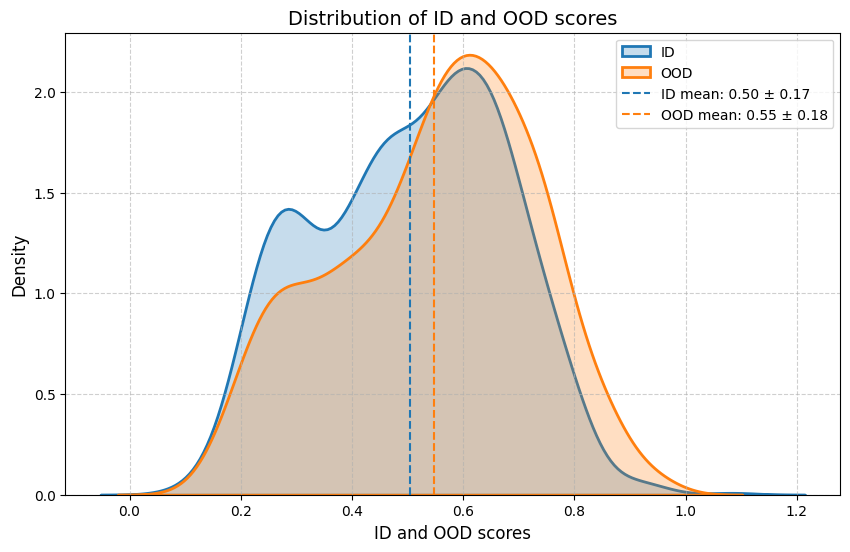

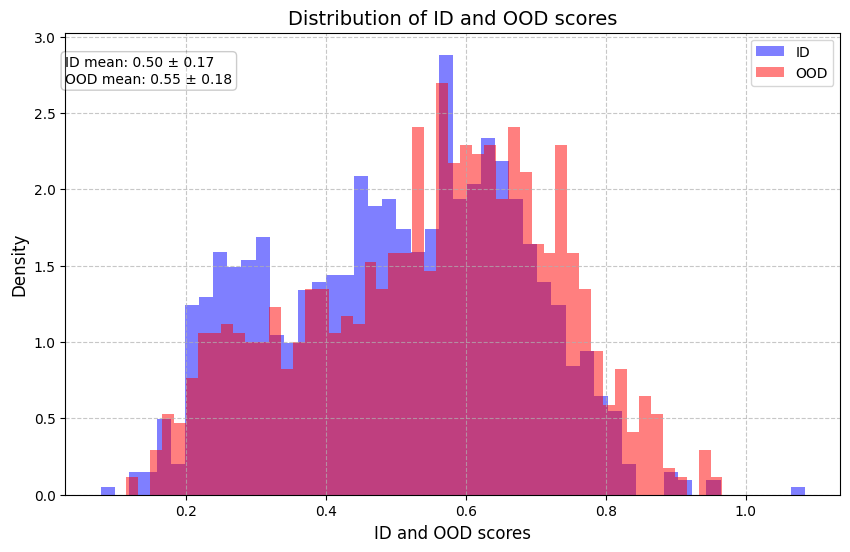

In [24]:
# Plot ID and OOD score distributions 
# -----------------------------------
from src.analysis.visualization import plot_score_distributions_kde, plot_score_distributions_hist
plot_score_distributions_kde(
    scores_id=scores_id,
    scores_ood=scores_ood,
    title="Distribution of ID and OOD scores",
    xlabel="ID and OOD scores"
    #save_path = f"{PLOT_DIR}densities{OUTPUT_TITLE}_k{k}.png"
)

plot_score_distributions_hist(
    scores_id=scores_id,
    scores_ood=scores_ood,
    title="Distribution of ID and OOD scores",
    xlabel="ID and OOD scores"
    #save_path = f"{PLOT_DIR}densities{OUTPUT_TITLE}_k{k}.png"
)


auROC: 0.5708
FPR95: 0.9380
AUC-PR: 0.5748
Optimal Threshold (Youden's J statistic): 0.5215


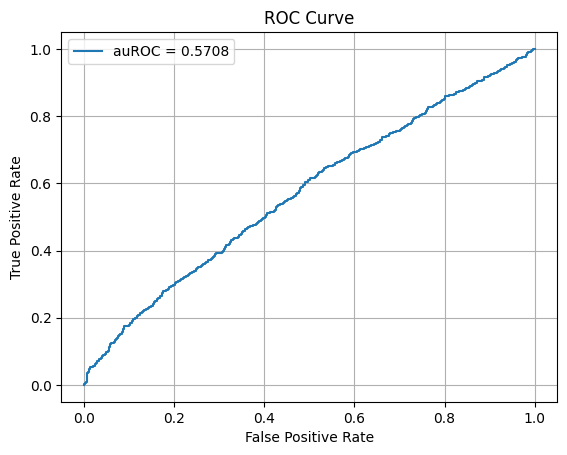

In [25]:
# Compute and plot auroc 
# -----------------------------------
from src.analysis.evaluation import compute_metrics
auroc, fpr95, auc_pr, fpr, tpr, thresholds, youden_threshold = compute_metrics(
    scores_id=scores_id, 
    scores_ood=scores_ood, 
    plot=True,
    #save_path= f"{PLOT_DIR}roc{OUTPUT_TITLE}_k{k}.png"
)

ᓚ₍ ^. ̫ .^₎

:'(

Accuracy: 0.9888
F1 score: 0.9889
Precision: 0.9794
Recall: 0.9986


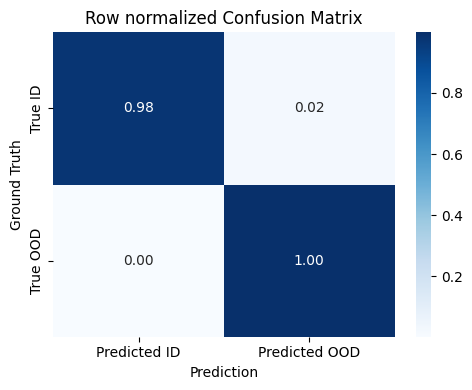

In [24]:
# Generate labels for each test point => 2 possible labels 
# -----------------------------------
"""
Predicted class is assigned as follows:
    - score >  threshold -> predicted OOD (label 1)
    - score <= threshold -> predicted ID (label 0)
"""
# Ground-truth labels: 0 for ID, 1 for OOD
y_true_thresh = np.concatenate((
    np.zeros(len(scores_id)),
    np.ones(len(scores_ood))
))
# Predicted labels based on threshold
y_pred_thresh = np.concatenate((
    (scores_id  > youden_threshold).astype(int), # 0=ID, 1=OOD
    (scores_ood > youden_threshold).astype(int)
))

# Result DataFrame: Add 2 class labels (based on Youden's threshold)
# -----------------------------------
df_result['label_2class'] = y_pred_thresh

# Compute confusion matrix
# -----------------------------------
from src.analysis.evaluation import compute_confusion_matrix_and_metrics
cm, accuracy, f1, precision, recall = compute_confusion_matrix_and_metrics(
    y_true=y_true_thresh,
    y_pred=y_pred_thresh,
    plot= True,
    normalize=True,
)

In [25]:
# Generate labels for each test point => 4 possible labels 
# -----------------------------------
'''
Class 0: ID well classified  (true ID,  score < threshold)
Class 1: OOD well classified (true OOD, score > threshold)
Class 2: OOD not detected    (true OOD, score < threshold)
Class 3: ID not detected     (true ID,  score > threshold)
'''
# Assumes that : Low score => ID, High score => OOD
labels_id_thresh  = np.where(scores_id  < youden_threshold, 0, 3)   # 0: ID correct, 3: ID not detected
labels_ood_thresh = np.where(scores_ood > youden_threshold, 1, 2)   # 1: OOD correct, 2: OOD not detected

# Result DataFrame: Add 4 class labels (well/wrongly classified)
# -----------------------------------
df_result['label_4class'] = np.concatenate([labels_id_thresh, labels_ood_thresh])

In [26]:
# Plot PCA, t-SNE and UMAP of classified samples  
# -----------------------------------
from src.analysis.visualization import plot_dim_reduction_3d_embeddings

pca_config = {'n_components': 3}
tsne_config = {'n_components': 3, 'perplexity': 100}
umap_config = {'n_components': 3, 'n_neighbors': 15, 'min_dist': 0.1}

# --- PCA only ---
_ = plot_dim_reduction_3d_embeddings(
    id_test_embeddings=id_test_embeddings, 
    od_test_embeddings=od_test_embeddings, 
    labels_id=labels_id_thresh, 
    labels_ood=labels_ood_thresh, 
    pca_config=pca_config
)


### Linear Probing

Accuracy: 0.7600
F1 score: 0.7526
Precision: 0.7766
Recall: 0.7300


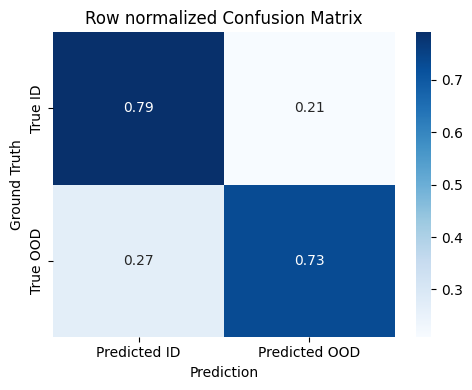

In [26]:
# ===================================
# Perform logistic regression 
# ===================================
from src.analysis.evaluation import compute_confusion_matrix_and_metrics
from src.ood_methods.logistic_regression import train_logistic_regression_on_embeddings

clf, y_true_probe, y_pred_probe, idx_test = train_logistic_regression_on_embeddings(
    id_test_embeddings, od_test_embeddings, random_state=SEED, test_size=0.1
)
cm, accuracy, f1, precision, recall = compute_confusion_matrix_and_metrics(
    y_true=y_true_probe,
    y_pred=y_pred_probe,
    plot=True,
    normalize=True,
) 

# Result DataFrame: Add labels predicted by logistic regression
# -----------------------------------
df_result['label_probing'] = np.nan  # init with NaN
df_result.loc[idx_test, 'label_probing'] = y_pred_probe.astype(int)

### Dataframe results

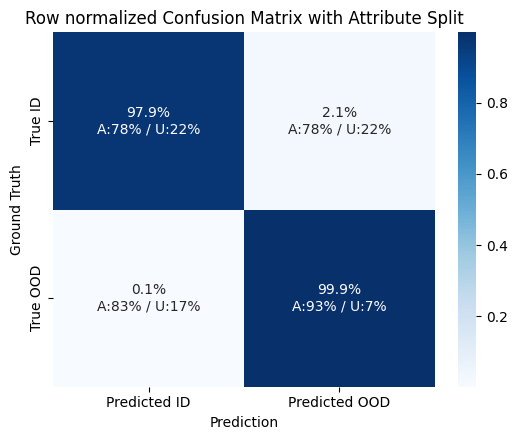

In [28]:
# Plot confusion matrix with unanswerable/answerable split
# -----------------------------------
from src.analysis.evaluation import compute_confusion_matrix_with_attribute_split

compute_confusion_matrix_with_attribute_split(
    y_true=y_true_thresh,
    y_pred=y_pred_thresh,
    attribute=df_result["is_unanswerable"].values,
    attr_labels=("A", "U"), 
    attr_true_value=True,
    normalize=True 
)

In [29]:
df_result

,set,index,is_unanswerable,ood_score,label_2class,label_4class,label_probing
0,ID,0,False,-0.998311,0,0,NaN
1,ID,1,False,-0.999479,0,0,NaN
2,ID,2,False,-0.999507,0,0,NaN
3,ID,3,False,-0.999506,0,0,NaN
4,ID,4,True,-0.999388,0,0,NaN
...,...,...,...,...,...,...,...
17515,OOD,8755,False,-0.877153,1,1,NaN
17516,OOD,8756,False,-0.820069,1,1,1.0
17517,OOD,8757,False,-0.813116,1,1,NaN
17518,OOD,8758,False,-0.829081,1,1,NaN


### Bootstrap analysis: determine optimal number of samples for best result

In [27]:
# ===================================
# Perform bootstrap analysis to determine the optimal 
# number of samples to obtain the best result
# ===================================
from src.analysis.bootstrap import bootstrap_analysis

# Define sample size ranges to be tested
# -----------------------------------
n_fit_samples_range = [10_000, 20_000, 40_000, 60_000, 70_000, 80_000]
n_test_samples_range = [1_000, 2_000, 4_000, 7_000, 8_000]

# Compute bootstrap analysis
# -----------------------------------
bootstrap_results = bootstrap_analysis(
    id_fit_embeddings=id_fit_embeddings,
    id_test_embeddings=id_test_embeddings,
    od_test_embeddings=od_test_embeddings,
    n_fit_samples=n_fit_samples_range,
    n_test_samples=n_test_samples_range,
    compute_ood_score_fn=compute_dknn_scores,
    n_bootstrap=50, 
    **config
)


Starting bootstrap analysis...


Fit samples:   0%|          | 0/6 [00:00<?, ?it/s]

Fit samples: 100%|██████████| 6/6 [36:36<00:00, 366.05s/it]


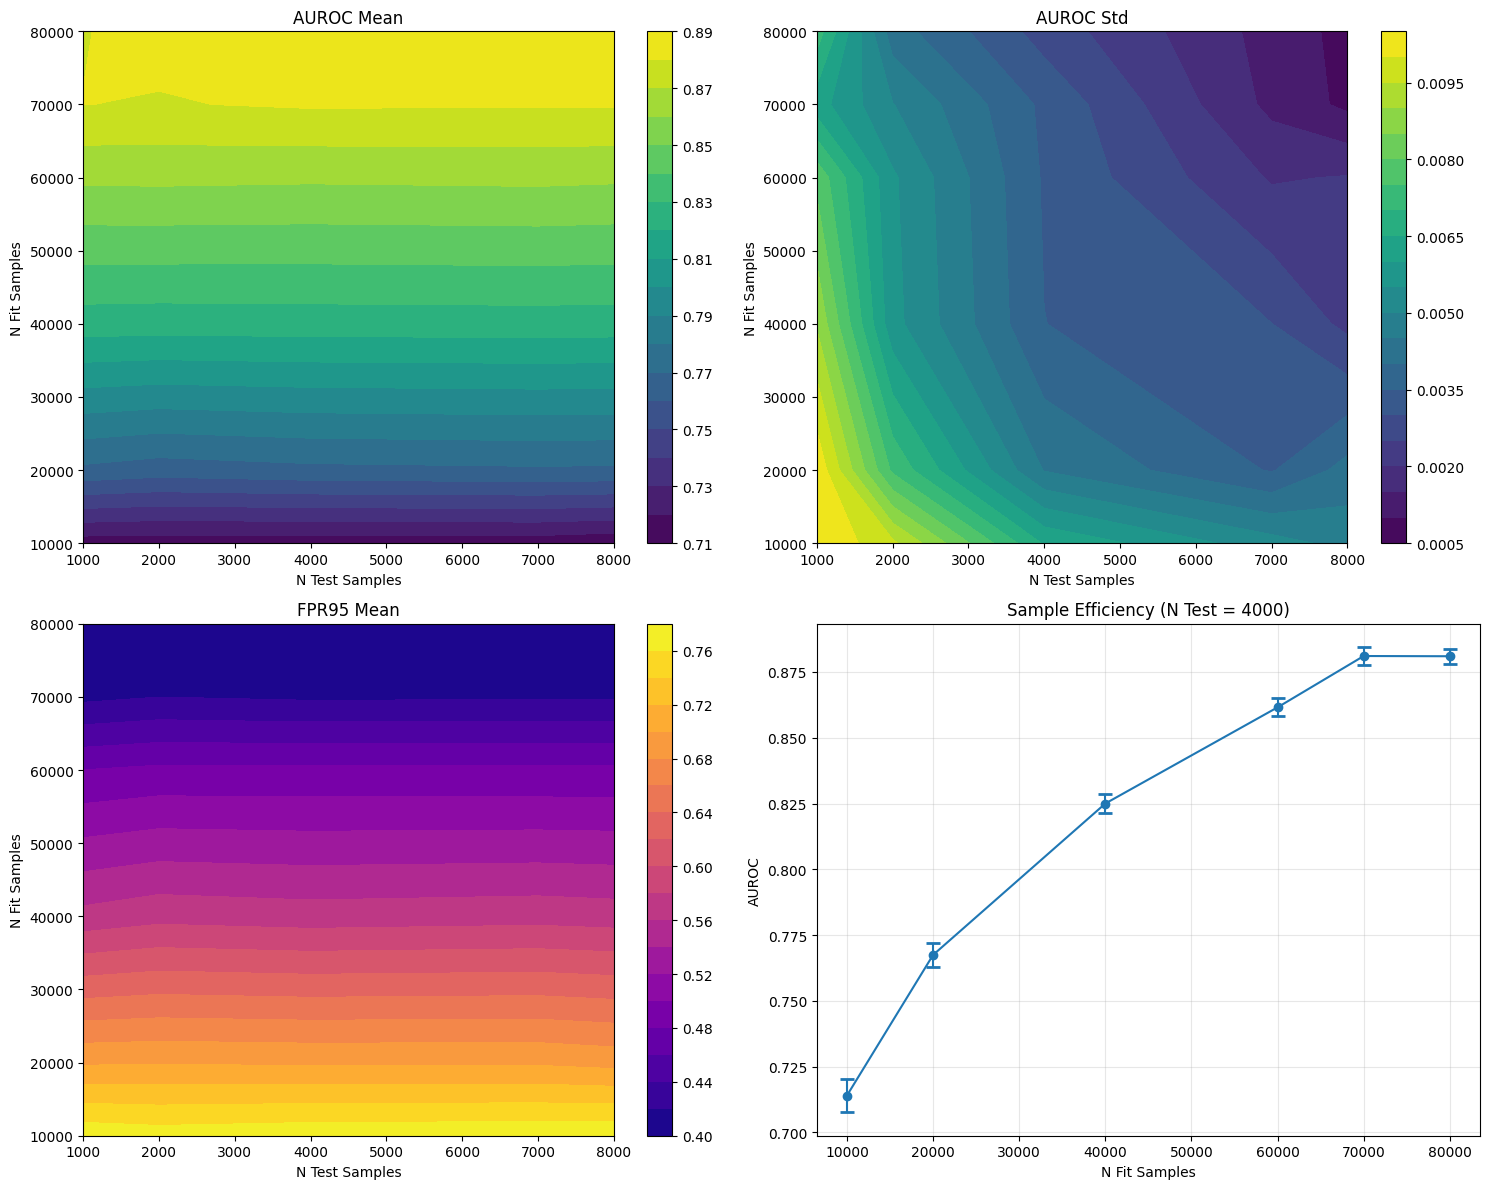


FINAL RESULTS

Bootstrap Analysis (averages over 6×5 configurations):
AUROC: 0.822 ± 0.005
AUPRC: 0.798 ± 0.006
FPR95: 0.560 ± 0.014

RECOMMENDATIONS

Optimal configuration found:
  - Fit samples: 80000
  - Test samples: 2000
  - AUROC: 0.882 ± 0.004

Saturation analysis:
  - With 10000 fit samples: AUROC = 0.822
  - With 80000 fit samples: AUROC = 0.821


In [29]:
# Visualize bootstrap analysis
# -----------------------------------
from src.analysis.bootstrap import plot_bootstrap_results, display_bootstrap_statistics

plot_bootstrap_results(bootstrap_results, save_path=f"{PLOT_DIR}bootstrap_analysis{OUTPUT_TITLE}.png")

display_bootstrap_statistics(bootstrap_results, n_fit_samples_range, n_test_samples_range)

### New

pour chaque question test, sortir la question fit la plus proche (a-t-on 2 fois la meme quesiton, les questions ont-elles le meme thème ? )

In [70]:
print(id_test_data.keys())
id_test_data['id'][0]

dict_keys(['id', 'original_indices', 'activations', 'gen_answers', 'is_unanswerable'])


'5a5e1d035bc9f4001a75ae34'

In [75]:
scores_id

array([0.00337756, 0.00104117, 0.00098574, ..., 0.00111246, 0.0008387 ,
       0.00478572], dtype=float32)

In [76]:
id_test_dataset[0]

{'id': '57097c8fed30961900e841f5',
 'title': 'Sky_(United_Kingdom)',
 'context': 'The Daily Mail newspaper reported in 2012 that the UK government\'s benefits agency was checking claimants\' "Sky TV bills to establish if a woman in receipt of benefits as a single mother is wrongly claiming to be living alone" – as, it claimed, subscription to sports channels would betray a man\'s presence in the household. In December, the UK’s parliament heard a claim that a subscription to BSkyB was ‘often damaging’, along with alcohol, tobacco and gambling. Conservative MP Alec Shelbrooke was proposing the payments of benefits and tax credits on a "Welfare Cash Card", in the style of the Supplemental Nutrition Assistance Program, that could be used to buy only "essentials".',
 'question': 'What was the UK governments benefits agenchy checking in 2012?',
 'answers': {'answer_start': 108, 'text': 'Sky TV bills'},
 'original_index': 2905,
 'is_impossible': 0}

In [7]:
import torch
import numpy as np
from typing import Tuple
from src.ood_methods.ood_utils import l2_normalize
from src.analysis.evaluation import compute_metrics
# if you have cuda version 12:
# uv pip install faiss-gpu-cu12
import faiss 


def fit_to_dataset(fit_embeddings: torch.tensor) -> faiss.Index:
    """
    Constructs the FAISS index from ID data.

    Parameters
    ----------
    fit_embeddings : torch.tensor
        ID embeddings, shape (N, D)

    Returns
    -------
    faiss.Index
        FAISS index built on the ID embeddings,  ready for k-NN search
    """
    dim = fit_embeddings.shape[1]  # embedding dimension
    fit_embeddings = np.array(fit_embeddings).astype(np.float32) # Convert to array 
    norm_fit_embeddings  = l2_normalize(fit_embeddings) # Normalize embeddings

    cpu_index = faiss.IndexFlatL2(dim) # Create a flat L2 index (exact search, not approximate)

    # If GPU requested, move index to GPU
    use_gpu = torch.cuda.is_available()
    if use_gpu:
        res = faiss.StandardGpuResources() # Allocate GPU memory
        index = faiss.index_cpu_to_gpu(res, 0, cpu_index) # Move index to GPU
    else:
        index = cpu_index

    # Add normalized ID embeddings to index
    index.add(norm_fit_embeddings)
    return index



def score_tensor(
    index: faiss.Index,
    inputs: torch.tensor,
    nearest: int = 50,
    batch_size: int = 4
) -> np.ndarray:
    """
    Compute DKNN OOD score for test embeddings.

    For each input sample, returns the distance to its k-th nearest neighbor
    (in the ID set) and the index of this neighbor in the reference set.

    Parameters
    ----------
    index : faiss.Index
        FAISS index built from ID data
    inputs : torch.tensor
        Array of test embeddings shape (N, D)
    nearest : int
        Number of nearest neighbors (k)
    batch_size : int
        Batch size for processing

    Returns
    -------
    np.ndarray
        Array of distances to the k-th nearest neighbor of shape (N,)
    np.ndarray
        Array of indices in the ID set for the k-th nearest neighbor, shape (N,).
    """

    # Convert to numpy float32 array
    inputs = np.array(inputs, dtype=np.float32)

    # Normalize the test embeddings
    norm_inputs = l2_normalize(inputs)

    # Allocate list to store distances and indices
    all_scores = []
    all_indices = []

    # Process in mini-batches to avoid memory overflow
    for i in range(0, norm_inputs.shape[0], batch_size):
        batch = norm_inputs[i:i + batch_size]               # Select batch
        distances, indices  = index.search(batch, nearest)  # FAISS k-NN search
        kth_dist = distances[:, -1]                         # Score = distance to k-th nearest neighbor
        kth_idx = indices[:, -1]                            # Index of the k-th nearest neighbor 
        all_scores.append(kth_dist)                         # Collect scores
        all_indices.append(kth_idx)                         # Collect indices
    
    # Concatenate results from all batches
    return np.concatenate(all_scores),  np.concatenate(all_indices)
### INDICES DECALES???? FAISS
    

def compute_dknn_scores(
    id_fit_embeddings: torch.Tensor,
    id_test_embeddings: torch.Tensor, 
    od_test_embeddings: torch.Tensor,
    k: int = 5,
    batch_size: int = 1000
) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """
    Compute DKNN (Deep k-Nearest Neighbors) scores for OOD detection.

    This function:
    - Fits a FAISS index on in-distribution embeddings
    - Computes DKNN scores (distance to k-th nearest neighbor) and indices for 
      both ID and OOD test samples.

    The DKNN score represents the distance to the k-th nearest neighbor in the 
    ID training set. Higher scores indicate samples that are far from the ID 
    distribution (likely OOD), while lower scores indicate samples close to 
    the ID distribution.

    Parameters
    ----------
    id_fit_embeddings : torch.Tensor
        In-distribution training embeddings used to fit the DKNN index.
        Shape: [n_fit_samples, embedding_dim]
    id_test_embeddings : torch.Tensor
        In-distribution test embeddings.
        Shape: [n_id_test_samples, embedding_dim]
    od_test_embeddings : torch.Tensor
        Out-of-distribution test embeddings.
        Shape: [n_ood_test_samples, embedding_dim]
    k : int, optional (default=5)
        Number of nearest neighbors used for scoring.
    batch_size : int, optional (default=1000)
        Batch size for scoring to manage memory.

    Returns
    -------
    dknn_scores_id : np.ndarray,  Shape: [n_id_test_samples]
        DKNN scores (distance to k-th nearest neighbor) for ID test samples. 
    dknn_scores_ood : np.ndarray, Shape: [n_ood_test_samples]
        DKNN scores for OOD test samples.  
    indices_id : np.ndarray, Shape: [n_id_test_samples]
        Indices in the ID set of the k-th nearest neighbor for each ID test sample.
    indices_ood : np.ndarray, Shape: [n_ood_test_samples]
        Indices in the ID set of the k-th nearest neighbor for each OOD test sample.
    """
    index = fit_to_dataset(id_fit_embeddings)

    dknn_scores_id, indices_id   = score_tensor(index, id_test_embeddings, nearest=k, batch_size=batch_size)
    dknn_scores_ood, indices_ood = score_tensor(index, od_test_embeddings, nearest=k, batch_size=batch_size)

    return dknn_scores_id, dknn_scores_ood, indices_id, indices_ood


In [13]:
# ===================================
# Perform DKNN
#
# A high DeepKNN score (distance to k-th NN) => OOD data (far from ID neighbors)
# A low DeepKNN score                        => ID data (close to ID neighbors)
# ===================================

# Define config
# -----------------------------------
config = {'k': 1, 'batch_size': BATCH_SIZE}

# Compute DKNN scores on test data
# -----------------------------------
scores_id, scores_ood, indices_id, indices_ood = compute_dknn_scores(
    id_fit_embeddings=id_fit_embeddings, 
    id_test_embeddings=id_test_embeddings, 
    od_test_embeddings=od_test_embeddings, 
    k=config['k'], 
    batch_size=config['batch_size']
)
print("Mean of ID scores:", np.mean(scores_id))
print("Mean of OOD scores:", np.mean(scores_ood))


Mean of ID scores: 0.007939342
Mean of OOD scores: 0.3082438


In [73]:
id_test_data['id'][0]

'5a5e1d035bc9f4001a75ae34'

In [53]:
indices_id

array([57052, 25678, 59808, ..., 32946, 52359, 60561])

In [14]:
def find_question_by_id(dataset, target_id):
    """
    Recherche la question correspondant à un id donné dans une liste de dicts SQuAD-like.

    Parameters
    ----------
    dataset : list of dict
        Liste des exemples, chaque élément doit avoir une clé 'id'
    target_id : str
        Identifiant recherché

    Returns
    -------
    question : str or None
        La question correspondante si trouvée, sinon None
    """
    for sample in dataset:
        if sample.get('id') == target_id:
            return f"Passage: {sample.get('context')}\nQuestion: {sample.get('question')}"
    return None



In [18]:
for i in range(10):
    qid = id_test_data['id'][i]
    print(qid)
    print("==== id_test_data: ====")
    res = find_question_by_id(od_test_dataset, qid) #od_test_dataset = id data in fact, 
    print(res)

    print("==== most similar id_fit_data: ====")
    context  = id_fit_dataset['context'][indices_id[i]+1]
    question = id_fit_dataset['question'][indices_id[i]+1]
    print(f"Passage: {context}\nQuestion: {question}")
    print("\n")


5a5e1d035bc9f4001a75ae34
==== id_test_data: ====
Passage: Scholars have debated the relationship and differences within āstika philosophies and with nāstika philosophies, starting with the writings of Indologists and Orientalists of the 18th and 19th centuries, which were themselves derived from limited availability of Indian literature and medieval doxographies. The various sibling traditions included in Hindu philosophies are diverse, and they are united by shared history and concepts, same textual resources, similar ontological and soteriological focus, and cosmology. While Buddhism and Jainism are considered distinct philosophies and religions, some heterodox traditions such as Cārvāka are often considered as distinct schools within Hindu philosophy.
Question: What are the two sibling traditions?
==== most similar id_fit_data: ====
Passage: The world's first Institute of Technology the Berg-Schola (Bergschule) established in Selmecbánya, Kingdom of Hungary by the Court Chamber of V

squad v2: train (answerable->ID fit, unanswerable) | val (answerable->ID test, unanswerable->OOD test)     => no theme overlap between train|val. Mais: les contextes (paragraphes Wikipédia) utilisés pour générer les questions unanswerable de SQuAD v2.0 sont les mêmes que ceux des questions answerable de SQuAD v1.1.